# Test ST notebook for XFEL based on Nikolay's pyrost

- uses the environment with pyrost and extra_data, extra_geom installed
- created hdf5 files with the assembled image based on the geom file (through the code from Chufeng)

In [76]:
import numpy as np
import os
import h5py
import hdf5plugin
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pyrost as rst
import pandas as pd
# import os
from extra_data import open_run, stack_detector_data
# from extra_geom import JUNGFRAUGeometry

# from CFL
from CBD_detector_Jungfrau_utils0 import read_train, get_3d_stack_from_train_ind

In [18]:
# !h5ls -r '/gpfs/exfel/exp/SPB/202302/p004456/scratch/vds/r0010.cxi'

In [19]:
# writing virtual cxi file
#!extra-data-make-virtual-cxi /gpfs/exfel/exp/SPB/202302/p004456/proc/r0010 -o /gpfs/exfel/exp/SPB/202302/p004456/scratch/vds/r0010.cxi

In [20]:
# !ls /gpfs/exfel/exp/SPB/202302/p004456/usr/Reports/r10

In [21]:
# proc folder
# !ls /gpfs/exfel/exp/SPB/202302/p004456/proc/r0010

In [6]:
!ls /gpfs/exfel/exp/SPB/202302/p004456/scratch/st_test

In [23]:
# raw folder
!ls /gpfs/exfel/exp/SPB/202302/p004456/raw/r0010

RAW-R0010-DA01-S00000.h5     RAW-R0010-JNGFR04-S00000.h5
RAW-R0010-DA02-S00000.h5     RAW-R0010-JNGFR05-S00000.h5
RAW-R0010-DA03-S00000.h5     RAW-R0010-JNGFR06-S00000.h5
RAW-R0010-DA04-S00000.h5     RAW-R0010-JNGFR07-S00000.h5
RAW-R0010-JNGFR01-S00000.h5  RAW-R0010-JNGFR08-S00000.h5
RAW-R0010-JNGFR02-S00000.h5  RAW-R0010-JNGFRCTRL00-S00000.h5
RAW-R0010-JNGFR03-S00000.h5


In [7]:
# !h5ls -r /gpfs/exfel/exp/SPB/202302/p004456/raw/r0010/RAW-R0010-DA01-S00000.h5

In [8]:
# !ls /gpfs/exfel/exp/SPB/202302/p004456/scratch/usr/geometry

In [9]:
prop_nr = 4456
run_nr = 10
run = open_run(prop_nr, run_nr)
# run.info()

In [17]:
# setting up the averaging for avg_nr frames - still work in progress for changing the logfile
avg = True
avg_nr = 3

N = 48 # the number of frames to read
start = 50 # fro which frame to start
end = start + N

test_stack = get_3d_stack_from_train_ind(prop_nr, run_nr, train_ind_tuple=(start,end,1), 
                            geom_file='/gpfs/exfel/exp/XMPL/201750/p700000/proc/r0040/j4m-p2805_v03.geom',
                            #'/gpfs/exfel/exp/SPB/202302/p004456/scratch/usr/geometry/geom_v5.geom',#
                            geom_assem='True')#, ROI=[500,1500,500,1500]) # roi also works now

image_array = test_stack['stack_arry_img_adc']
# image_array = test_stack['stack_arry_img_adc'] * test_stack['stack_arry_img_mask']


if avg:
    out_array = np.mean(image_array.reshape(-1, avg_nr, image_array.shape[1], image_array.shape[2]), axis=1)
else:
    out_array = image_array
    
# saving the hdf5 file to be given to Speckle tracking CXIStore
output_file_path = f'/gpfs/exfel/exp/SPB/202302/p004456/scratch/st_test/assembled_run_{run_nr}.hdf5'
with h5py.File(output_file_path, 'w') as output_file:
    output_file.create_dataset('/entry/data/data', data=out_array)
print(f'Saved to {output_file_path}')

  0%|          | 0/48 [00:00<?, ?it/s]

Saved to /gpfs/exfel/exp/SPB/202302/p004456/scratch/st_test/assembled_run_10.hdf5


In [40]:
!h5ls -r /gpfs/exfel/exp/SPB/202302/p004456/scratch/st_test/assembled_run_10.hdf5

/                        Group
/entry                   Group
/entry/data              Group
/entry/data/data         Dataset {16, 2164, 2234}


In [41]:
test_stack.keys()

dict_keys(['stack_arry_module_adc', 'stack_arry_module_gain', 'stack_arry_module_mask', 'stack_arry_img_adc', 'stack_arry_img_gain', 'stack_arry_img_mask'])

In [49]:
data_file = '/gpfs/exfel/exp/SPB/202302/p004456/scratch/st_test/assembled_run_10.hdf5'
protocol = rst.CXIProtocol.import_default()

with h5py.File(data_file) as cxi_file:
    cxi_path = protocol.find_path('data', cxi_file)
    print(cxi_path)
    print(rst.CXIProtocol.read_dataset_shapes(cxi_path, cxi_file))

/entry/data/data
{'/entry/data/data': (16, 2164, 2234)}


In [50]:
# Creating a file handler for the file

cxi_file = rst.CXIStore(data_file, 'r')

# Printing all the data attributes stored in the file

print(list(cxi_file))

# Printing a list of frame indices stored in the file

print(cxi_file.indices())

['data']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [51]:
# loading the data

with rst.CXIStore(data_file) as cxi_file:
    data = cxi_file.load_attribute('data', processes=8, verbose=True)

Loading data:   0%|          | 0/16 [00:00<?, ?it/s]

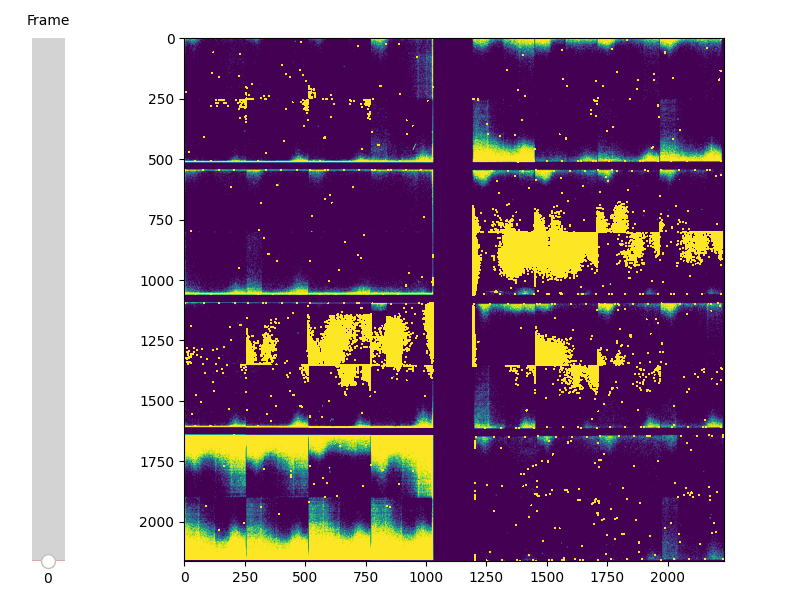

In [52]:
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [0.1, 1.0]})

slider = Slider(ax=ax[0], label='Frame', valmin=0, valmax=19,
                valstep=np.arange(0, 20),
                valinit=0, orientation="vertical")

im0 = ax[1].imshow(data[0], vmin=0, vmax=1)

def update(event):
    im0.set_data(data[slider.val])
    fig.canvas.draw_idle()

slider.on_changed(update)

fig.tight_layout()

plt.show()

## Logdata

In [53]:
run = open_run(prop_nr, run_nr)
sam_x = run['SPB_IRU_SACT/MOTOR/CHAN0', 'actualPosition'].xarray()
sam_y = run['SPB_IRU_SACT/MOTOR/CHAN1', 'actualPosition'].xarray()

In [54]:
#sam_x.values

In [55]:
# %matplotlib widget
# fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(sam_x.trainId.values, sam_x.values, 'o', label='sam-x')
# ax.plot(sam_x.trainId.values, sam_y.values, 'o',label='sam-y')
# ax.set_xlabel('TrainID')
# ax.set_ylabel('position (mm)')
# ax.legend()

In [56]:
# probably unnecessary - sorting by trainID values
df_log_x = pd.DataFrame({'trainID': sam_x.trainId.values, 'CHAN0': sam_x.values})
df_log_y = pd.DataFrame({'trainID': sam_y.trainId.values, 'CHAN1': sam_y.values})

df_log = pd.merge(df_log_x, df_log_y, on='trainID', how='outer')
df_log

,trainID,CHAN0,CHAN1
0,1852107820,-0.000002,-1.014940
1,1852107821,-0.000002,-1.014940
2,1852107822,-0.000002,-1.014940
3,1852107823,-0.000002,-1.014940
4,1852107824,-0.000002,-1.014940
...,...,...,...
258,1852108078,-0.000001,-0.200675
259,1852108079,-0.000001,-0.200675
260,1852108080,-0.000001,-0.200675
261,1852108081,-0.000001,-0.200675


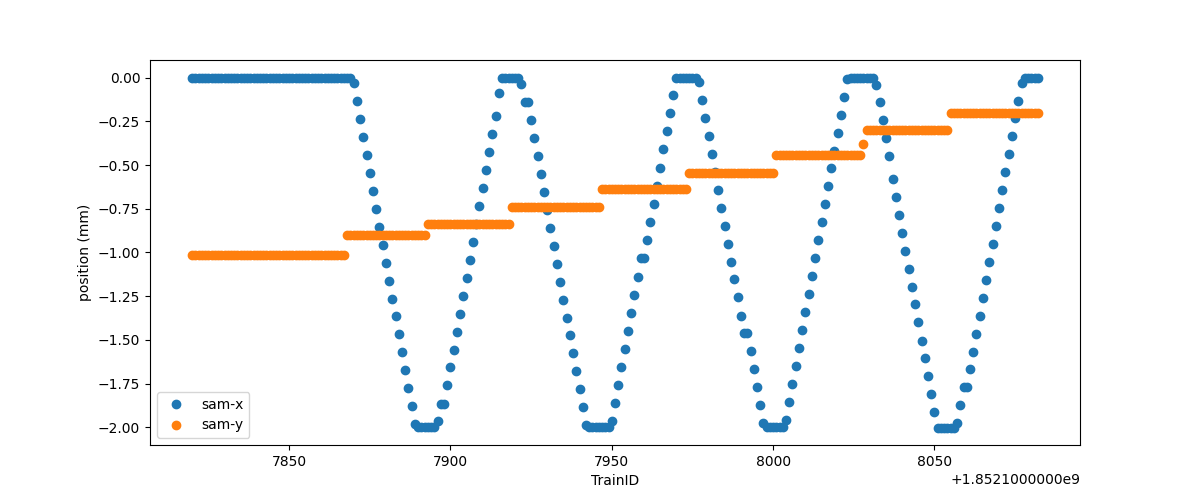

In [57]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_log['trainID'], df_log['CHAN0'], 'o',label='sam-x')
ax.plot(df_log['trainID'], df_log['CHAN1'], 'o',label='sam-y')
ax.set_xlabel('TrainID')
ax.set_ylabel('position (mm)')
ax.legend()

In [58]:
unique_pairs = df_log[['CHAN0', 'CHAN0']].drop_duplicates()
len(unique_pairs)

167

Text(0, 0.5, 'SAM-Y / CHAN 1')

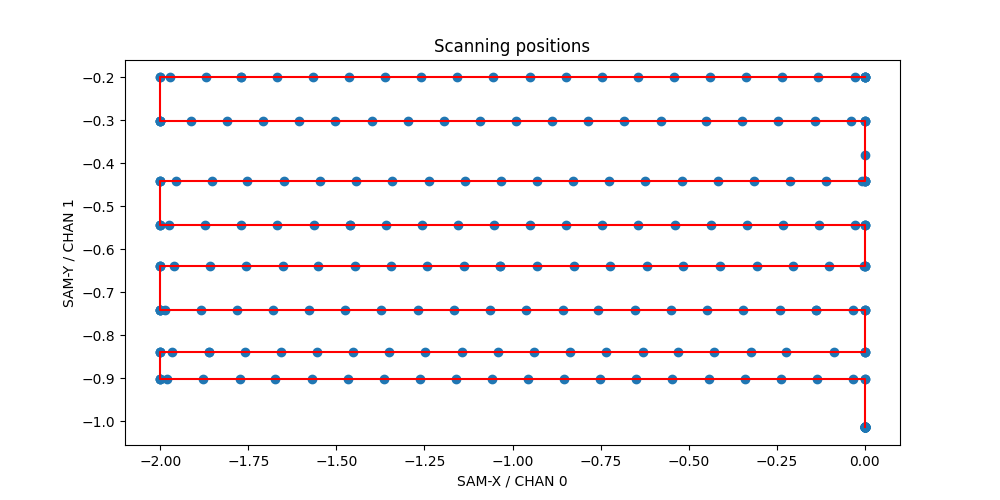

In [61]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Scanning positions')
ax.scatter(df_log.CHAN0, df_log.CHAN1)
ax.plot(df_log.CHAN0, df_log.CHAN1, color='red')
ax.set_xlabel('SAM-X / CHAN 0')
ax.set_ylabel('SAM-Y / CHAN 1')

In [62]:
sim_log = {'x_pixel_size': 7.5e-05, 'y_pixel_size': 7.5e-05, 'basis_vectors': None, 'translations' : None}

fs_vec = np.array([-75e-6, 0., 0.])
ss_vec = np.array([0., -75e-6, 0.])
cell = np.stack([ss_vec, fs_vec])

basis_vectors = np.tile(cell,(N,1,1))

sim_log['basis_vectors'] = basis_vectors

z = 0 #z0 could probably also be read from the log, but doesn't really matter
# N = 27 # should be the number of frames

fill_array = np.zeros([N, 3])

for i in range(0,N):
    # 1e-3 because the values in the xfel logfile are in mm
    x = df_log['CHAN0'][start+i]*1e-3
    y = df_log['CHAN1'][start+i]*1e-3
    fill_array[i,:] = np.array([x,y,z])
sim_log['translations'] = fill_array

In [63]:
sim_log['translations'].shape

(48, 3)

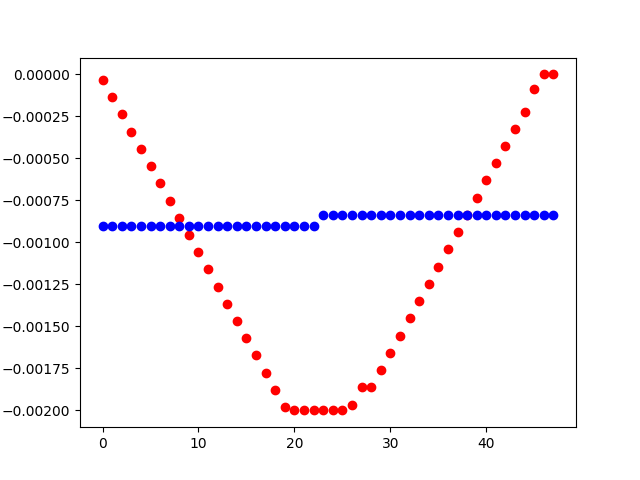

In [64]:
fig, ax = plt.subplots()
ax.plot(sim_log['translations'][:, 0], 'o', color='red')
ax.plot(sim_log['translations'][:, 1], 'o', color='blue')

# Cropping and processing

In [65]:
# roi for the full pupil
roi = (1000, 2000, 1000, 2000) # y_min, y_max, x_min, x_max 

# roi = (2400, 3150, 2410, 3200)

transform = rst.ComposeTransforms((rst.Crop(roi), rst.Downscale(1))) #2

In [66]:
distance = 1 # meters
en_to_wl = 12398.419297617678e-10 # h * c / e [eV * m]
wavelength = en_to_wl / 17.5e3

# Creating the main ST dataset container

st_data = rst.STData(input_file=rst.CXIStore(data_file, 'r'), transform=transform, **sim_log,
                     distance=distance, wavelength=wavelength)

In [67]:
# Loading detector data from the st_data.input_file

st_data = st_data.load('data', processes=8)

Loading data:   0%|          | 0/16 [00:00<?, ?it/s]

In [68]:
st_data = st_data.update_mask(method='range-bad', vmax=1000000)

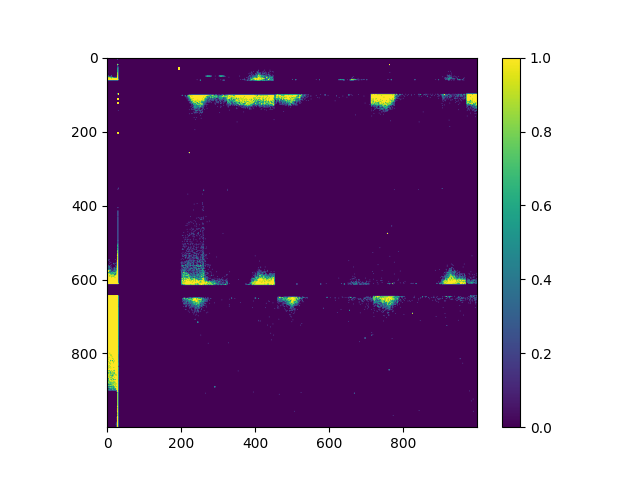

In [69]:
fig, ax = plt.subplots()
im = ax.imshow(st_data.whitefield, vmin=0, vmax = 1)
# ax.set_title(f'Scan_{scan_num} whitefield')
plt.colorbar(im, ax = ax)
# plt.savefig(f'results/Scan_{scan_num}_whitefield.png', bbox_inches = 'tight', dpi=100)

In [70]:
st_data = st_data.mask_frames()

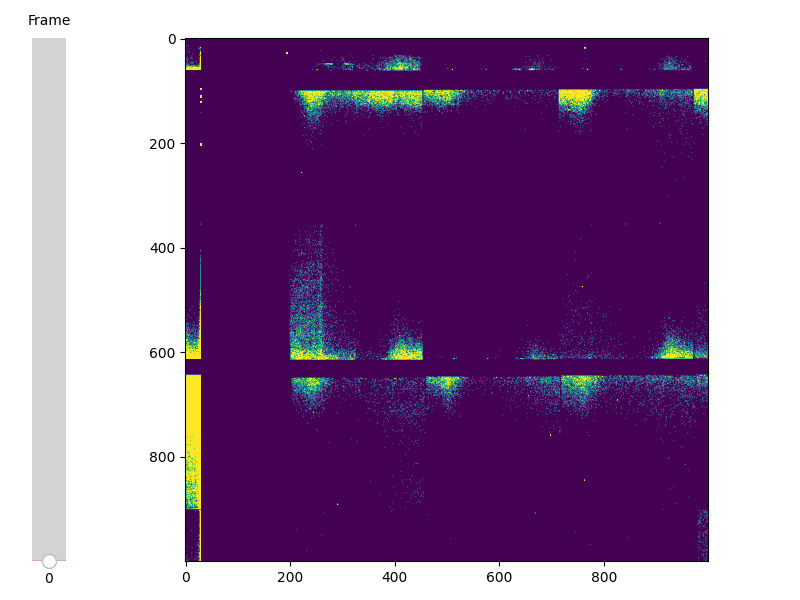

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [0.1, 1.0]})

slider = Slider(ax=ax[0], label='Frame', valmin=0, valmax=19,
                valstep=np.arange(0, 20),
                valinit=0, orientation="vertical")

im0 = ax[1].imshow(st_data.data[0] * st_data.mask[0], vmin=0, vmax=1)

def update(event):
    im0.set_data(st_data.data[slider.val] * st_data.mask[slider.val])
    fig.canvas.draw_idle()

slider.on_changed(update)

fig.tight_layout()
plt.show()

## Finding defocus

In [72]:
defoci_x = np.linspace(260e-6, 600e-6, 10)
defoci_y = np.linspace(260e-6, 600e-6, 10)

defoci_x, defoci_y = np.meshgrid(defoci_x, defoci_y)

# sweep_scan is the figure of merit of sharpness, it's maximised at the correct defocus distance
# size - the size of the local standard deviation filter,
#        the higher it is the lower spatial frequencies you take into account
# ds_x, ds_y - sampling intervals of the reference image in pixels
# hval - kernel bandwidth used in the reference image reconstruction,
#        the higher it is the blurrier the image is

sweep_scan, extra = st_data.defocus_sweep(defoci_x, defoci_y, size=50, hval=1.0,
                                          extra_args={'ds_x': 3.0, 'ds_y': 3.0},
                                          return_extra=True, verbose=True)

Generating defocus sweep:   0%|          | 0/100 [00:00<?, ?it/s]

In [73]:
# reshaping the R-values into an image

sweep_scan = np.array(sweep_scan).reshape(defoci_x.shape)

In [74]:
# Finding the optimal defoci

index = np.unravel_index(np.argmax(sweep_scan), defoci_x.shape)
defocus_x, defocus_y = defoci_x[index], defoci_y[index]
print(defocus_x*1e6, defocus_y*1e6)

600.0 524.4444444444443


In [72]:
# %matplotlib widget
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.imshow(sweep_scan)
# fig.tight_layout()
# plt.show()

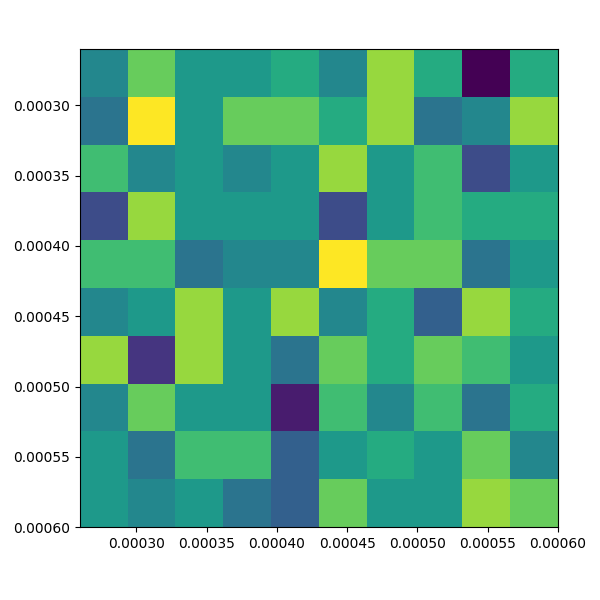

In [73]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(sweep_scan, extent=[defoci_x.min(), defoci_x.max(),
                              defoci_y.max(), defoci_y.min()])
fig.tight_layout()
plt.show()

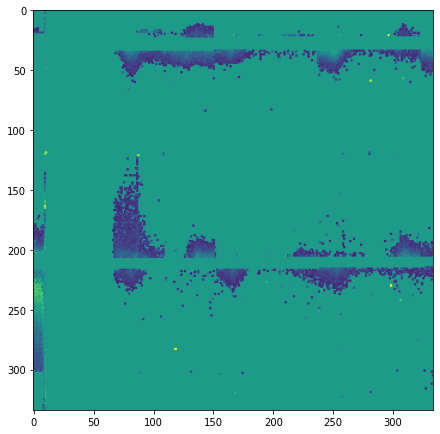

In [74]:
# plotting the reference image corresponding to the optimal defocus distance

%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout = True)
ax.imshow(extra['reference_image'][np.argmax(sweep_scan)], vmin=0.4, vmax=1.5)
# ax.set_title(f'Scan {scan_num}, reference image')
# plt.savefig(f'results/Scan_{scan_num}_ref_image_auto.png', bbox_inches = 'tight', dpi=100)
plt.show()

In [75]:
# parsing the found defoci to the ST data container

st_data = st_data.update_defocus(defocus_x, defocus_y)


### 4. Performing iterative PXST reconstruction

pyrost.SpeckleTracking provides an interface to iteratively refine the reference image and lens wavefront.
It offers two methods to choose from:

* `pyrost.SpeckleTracking.train` : performs the iterative reference image
  and pixel mapping updates with the constant kernel bandwidths for the reference image
  estimator (`h0`).

* `pyrost.SpeckleTracking.train_adapt` : does ditto, but updates the bandwidth
  value for the reference image estimator at each iteration by the help of the BFGS method
  to attain the minimal error value.

In [76]:
# generating a speckle tracking "reconstructer"
# ds_x, ds_y - sampling intervals of the reference image in pixels

st_obj = st_data.get_st(ds_x=5.0, ds_y=5.0)

In [77]:
# finding the optimal reference image bandwidth
#
# kernel bandwidth used in the reference image reconstruction,
# the higher it is the blurrier the image is
#
# The cross validation error is minimized when the kernel bandwidth is "right"
# CV -> https://towardsdatascience.com/what-is-cross-validation-60c01f9d9e75

h_vals = np.linspace(0.5, 3.0, 25)
cv_vals = st_obj.CV_curve(h_vals)

Calculating CV:   0%|          | 0/25 [00:00<?, ?it/s]

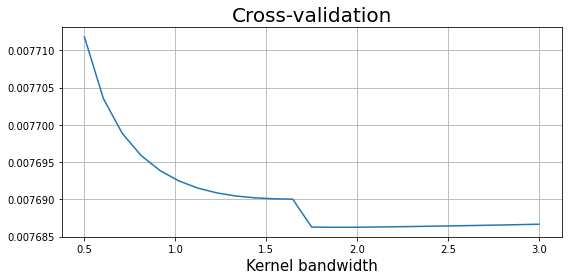

In [79]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(h_vals, cv_vals)
ax.set_xlabel('Kernel bandwidth', fontsize=15)
ax.set_title('Cross-validation', fontsize=20)
ax.tick_params(labelsize=10)
ax.grid(True)
fig.tight_layout()
plt.show()

#### Performing the reconstruction

`pyrost.SpeckleTracking` provides an interface to perform the reference image and lens wavefront
reconstruction and offers two methods:

1. **`pyrost.SpeckleTracking.train`** - iterative update with the static bandwidth
2. **`pyrost.SpeckleTracking.train_adapt`** - iterative update with the adpatively updated bandwidth

The typical reconstruction cycle consists of:

* Estimating an optimal kernel bandwidth for the reference image estimate (`pyrost.SpeckleTracking.find_hopt`,
  in `pyrost.SpeckleTracking.train_adapt` only).
* Generating the reference image (`pyrost.SpeckleTracking.update_reference`).
* Updating the discrete (pixel) mapping between a stack of frames and the generated reference image
  (`pyrost.SpeckleTracking.update_pixel_map`).
* Updating the sample translations vectors (`pyrost.SpeckleTracking.update_translations`).
* Calculating figures of merit (`pyrost.SpeckleTracking.ref_total_error`,
  `pyrost.SpeckleTracking.error_profile`).
  
`pyrost.SpeckleTracking.train_adapt` parameters:
- `search_window` : A tuple of three elements ('sw_y', 'sw_x', 'sw_s'). The elements are the following:

    * `sw_y` : Search window size in pixels along the horizontal detector axis.
    * `sw_x` : Search window size in pixels along the vertical detector axis.
    * `sw_s` : Search window size of the Huber scaling map. Given as a ratio (0.0 - 1.0) relative to the scaling map value before the update.

- `h0` : Initial kernel bandwidth used in `reference_image` estimation. The value is given in pixels.
- `blur` : Smoothing kernel bandwidth used in `pixel_map` regularisation. The value is given in pixels.
- `n_iter` : Maximum number of iterations.

In [80]:
h0 = h_vals[np.argmin(cv_vals)]

# performing the PXST reconstruction with adaptive bandwidth
# performing the update first with high 'blur' value to supress any artifacts in pixel_map

# more info -> https://robust-speckle-tracking.readthedocs.io/en/latest/reference/rst_ref.html

st_adapt = st_obj.train_adapt(search_window=(4.0, 4.0, 0.1), h0=h0, blur=200.0,  n_iter=10,
                              pm_method='rsearch', pm_args={'n_trials': 50}) # f_tol = -1 n_iter=10

   0%            Iteration 0 / 10 [00:00<?, ?it/s]

Initial error = 0.037519, Initial h0 = 1.85


To avoid the lines to jump for Mo2C, one needs to set a large blur for the first st adapt

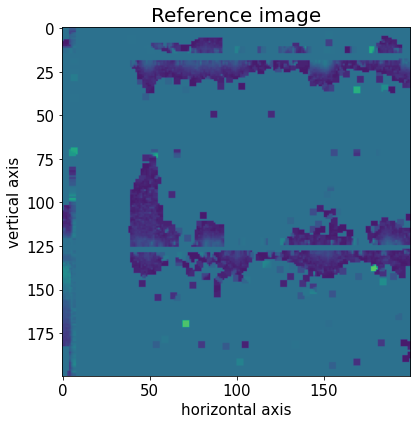

In [82]:

fig, ax = plt.subplots(figsize=(7, 6))
ax.imshow(st_adapt.reference_image, vmin=0.4, vmax=2.0)
ax.set_title('Reference image', fontsize=20)
ax.set_xlabel('horizontal axis', fontsize=15)
ax.set_ylabel('vertical axis', fontsize=15)
ax.tick_params(labelsize=15)
# plt.savefig(f'results/Scan_{scan_num}_ref_image_refined_0.png', bbox_inches = 'tight', dpi=100)
fig.tight_layout()
plt.show()

In [83]:
# performing the fine update with lower 'blur' value

st_adapt = st_adapt.train_adapt(search_window=(5.0, 5.0, 0.1), h0=h0, blur=60.0, n_iter=10,
                                pm_method='rsearch', pm_args={'n_trials': 75})

   0%            Iteration 0 / 10 [00:00<?, ?it/s]

Initial error = 0.026771, Initial h0 = 1.85


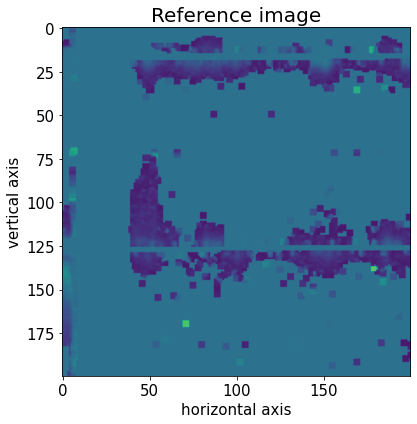

In [84]:
# Plotting the reconstructed reference image
# All the blurriness has to be corrected after the update

fig, ax = plt.subplots(figsize=(7, 6))
ax.imshow(st_adapt.reference_image, vmin=0.4, vmax=2.0)
ax.set_title('Reference image', fontsize=20)
ax.set_xlabel('horizontal axis', fontsize=15)
ax.set_ylabel('vertical axis', fontsize=15)
ax.tick_params(labelsize=15)
# plt.savefig(f'results/Scan_{scan_num}_ref_image_refined_1.png', bbox_inches = 'tight', dpi=100)
fig.tight_layout()
plt.show()

In [ ]:
np.shape(st_adapt.reference_image)

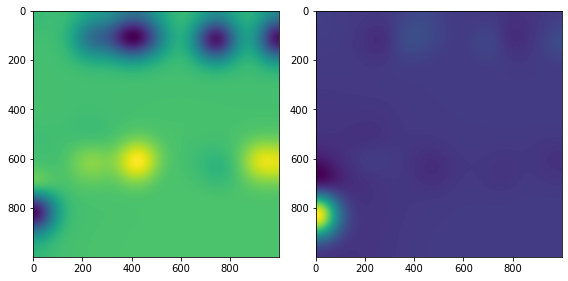

In [86]:
# Plotting the reconstructed pixel_map
# You expect to see a smooth profile with following the third polynomial

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow((st_adapt.pixel_map[0] - st_obj.pixel_map[0]))
ax[1].imshow((st_adapt.pixel_map[1] - st_obj.pixel_map[1]))
fig.tight_layout()
plt.show()

### 4. Phase reconstruction

We got the pixel mapping from the detector plane to the reference plane, which can
be easily translated to the angular displacement profile of the lens. One can reconstruct
the lens' phase profile with `pyrost.STData.import_st` method. Besides, one can fit the phase
profile with a polynomial function using `pyrost.AberrationsFit` fitter object,
which can be obtained with `pyrost.STData.get_fit` method.

In [87]:
# Generating a phase out of st_adapt.pixel_map
# The phase is saved into st_data.phase

st_data.import_st(st_adapt)

In [88]:
# Fitting the phase profile with st_data.get_fit
# axis - 0 for y axis and 1 for x axis

fit_obj_ss = st_data.get_fit(axis=0)
fit_ss = fit_obj_ss.fit(max_order=3)
fit_obj_fs = st_data.get_fit(axis=1)
fit_fs = fit_obj_fs.fit(max_order=3)
print(fit_fs['c_3'], fit_fs['c_4'], fit_ss['c_3'], fit_ss['c_4'])

0.00040989801839327736 -2.3594022223722304e-06 -0.00041101192434314746 1.0851442376550543e-06


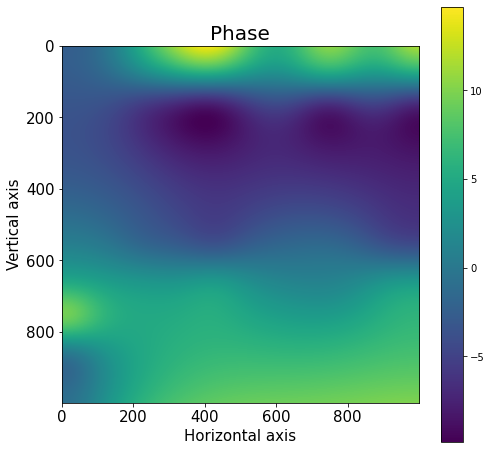

In [89]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(st_data.get('phase'))
ax.set_title('Phase', fontsize=20)
ax.set_xlabel('Horizontal axis', fontsize=15)
ax.set_ylabel('Vertical axis', fontsize=15)
ax.tick_params(labelsize=15)
plt.colorbar(im, ax=ax)
plt.show()

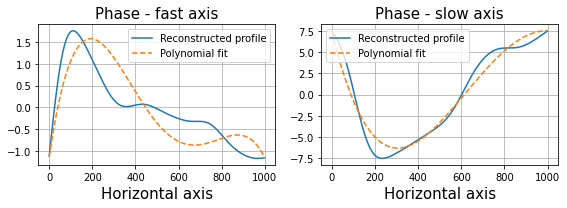

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(fit_obj_fs.pixels, fit_obj_fs.phase, label='Reconstructed profile')
axes[0].plot(fit_obj_fs.pixels, fit_obj_fs.model(fit_fs['ph_fit']), linestyle='dashed',
                 label='Polynomial fit')
axes[0].set_xlabel('Horizontal axis', fontsize=15)
axes[1].plot(fit_obj_ss.pixels, fit_obj_ss.phase, label='Reconstructed profile')
axes[1].plot(fit_obj_ss.pixels, fit_obj_ss.model(fit_ss['ph_fit']), linestyle='dashed',
             label='Polynomial fit')
axes[1].set_xlabel('Horizontal axis', fontsize=15)
for ax in axes:
#     ax.set_title('Phase', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=10)
    ax.grid(True)
axes[0].set_title('Phase - fast axis', fontsize=15)
axes[1].set_title('Phase - slow axis', fontsize=15)
fig.tight_layout()
plt.show()

In [91]:
defocus_x, defocus_y

(0.0002977777777777778, 0.0002977777777777778)

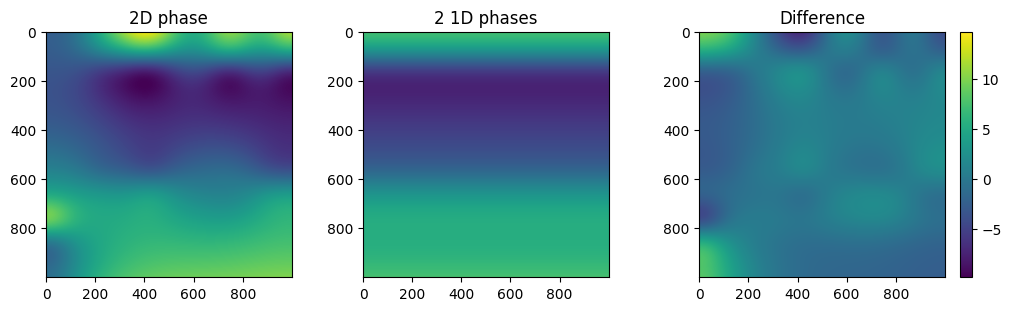

In [92]:
%matplotlib inline

phase_2d = st_data.get('phase')

phase_x = np.average(phase_2d, axis = 1)
phase_y = np.average(phase_2d, axis = 0)

phase_2d_ideal = np.zeros(phase_2d.shape)

for i in range(phase_2d_ideal.shape[0]):
    for j in range(phase_2d_ideal.shape[1]):
        phase_2d_ideal[i,j] = phase_x[i] + phase_y[j]

fig,ax = plt.subplots(nrows = 1, ncols = 3, figsize=(10,3), dpi=100, constrained_layout=True)
min_counts = phase_2d.min()
max_counts = phase_2d.max()

ax[0].imshow(phase_2d, vmin=min_counts, vmax = max_counts)
ax[0].set_title('2D phase')

ax[1].imshow(phase_2d_ideal, vmin=min_counts, vmax = max_counts)
ax[1].set_title('2 1D phases')

im = ax[2].imshow(phase_2d_ideal- phase_2d, vmin=min_counts, vmax = max_counts)
ax[2].set_title('Difference')

plt.colorbar(im, ax=ax[2])

In [939]:
# # Creating an output file test.h5

# output_file = rst.CXIStore('test.h5', 'a')

# # Parsing the file to the ST data container

# st_data = st_data.update_output_file(output_file)

# # Saving the results into the file

# st_data.save(mode='overwrite')

In [75]:
# !h5ls -r test.h5